In [1]:
import numpy as np

import scipy.special.lambertw as W

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# default graphics size:
plt.rcParams["figure.figsize"] = (10,10)
# default colormap:
plt.rcParams['image.cmap'] = 'gray'
# define transparent colormaps:
red = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmapblue', red, N=2)
blue = [(0,0,1,c) for c in np.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmapred', blue, N=2)
green = [(0,1,0,c) for c in np.linspace(0,1,100)]
cmapgreen = mcolors.LinearSegmentedColormap.from_list('mycmapgreen', green, N=2)
# background map:
background = plt.imread("cité-scientifique.png")

# Privacy Preserving Machine Learning: <br> Final Report

Complements to the report on the paper __Geo-indisguishability: Differential Privacy for Location-Based Systems__ by _Maxence Giraud_ and _Nicola Zotto_

## Implementation of the Planar Laplace mechanism $PL_\epsilon$

In [3]:
def PL_espilon(x, epsilon, u, v, delta_angle, delta_radius, A, A_diam):
    """
    Implementaiton of the mechanism for geo-indistinguishability proposed in the paper (see figure 6).
    :arg x: true position
    :arg epsilon: desired privacy parameter
    :arg u: step size of the Cartesian grid on the x axis
    :arg v: step size of the Cartesian grid on the y axis
    :arg delta_angle: machine precision on the sampling of the angle
    :arg delta_radius: machine precision on the sampling of the radius
    :arg A: area of interest, a subset of the Cartesian grid
    :arg A_diam: diameter of the area of interest.
    :return: Sanitized and private location z.
    """
    assert(A_diam < (u/delta_angle))
    # computing epsilon':
    min_unit = min(u, v)
    q = min_unit/(A_diam * delta_angle)
    candidate_eps_prim = np.linspace(0, epsilon, 100)
    candidate_test = candidate_eps_prim + 1/min_unit * np.log((q + 2*np.exp(candidate_eps_prim * min_unit))/(q - 2*np.exp(candidate_eps_prim * min_unit)))
    eps_prime = np.max(np.where(candidate_test<epsilon, candidate_eps_prim, 0))
    # generate Laplacian noise:
    theta = np.random.random() * 2*np.pi
    p = np.random.random()
    r = -1/eps_prime * (W(p-1/eps_prime, k=-1) + 1)
    # generate z:
    z = x + np.array([r * np.cos(theta), r*np.sin(theta)])
    # map z to A:
    dist = A - z
    z = A[np.argmin(dist)]
    return z

## Experimental setup

We define a 2D grid `G` with values ranging from (0,0) to (1000,1000) with a step size (10,10) to model the spacial representation of a __location based system (LBS)__.

We will simulate a querie of the LBS by drawing at random the true location `x` of a user. The area of interest `A` of this user will be within a radius of 200 around this users true location. The area of research of the query is set to 500.

Since we are using Python for our implementation, the machine representation of floating points is set to `double digit precision` by default i.e. there are 16 significant digits.

In [4]:
# Definitions :
u = 10 
v = 10
delta_ang = 10**-16
delta_rad = 10**-16
G = np.zeros((100,100))
G_x, G_y = np.meshgrid(np.arange(0, 1001, 10), np.arange(0, 1001, 10))
r_AOI = 50
r_AOR = 200
epsilon = 0.5

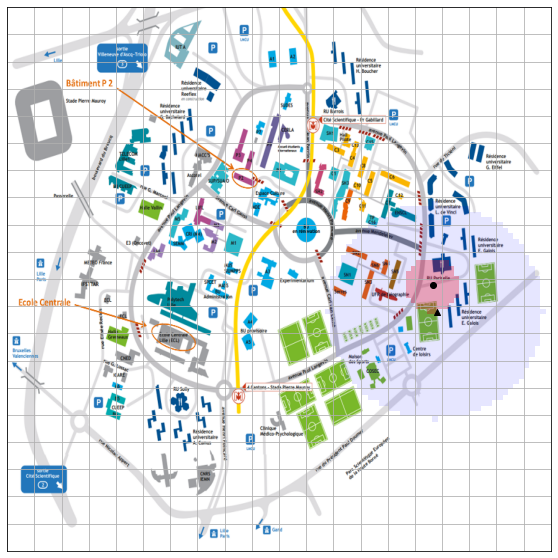

In [5]:
# Sampling the real location x:
x = np.random.randint(1000, size=2)

# Defining the area of interest A:
circle_AOI = np.sqrt((G_x-x[0])**2+(G_y-x[1])**2)
mask_AOI = np.where(circle_AOI<=r_AOI, True, False)
A = np.fliplr(np.array(list(zip(*np.where(mask_AOI)))) * np.array((u, v)))

# Generating the private location z:
z = PL_espilon(x, epsilon, u, v, delta_ang, delta_rad, A, r_AOI)

# Define the area of research R:
circle_AOR = np.sqrt((G_x-z[0])**2+(G_y-z[1])**2)
mask_AOR = np.where(circle_AOR<=r_AOR, True, False)

# Display
fig, ax = plt.subplots()
ax.imshow(background, extent=[0, 1000, 0, 1000])
ax.scatter(x[0], x[1], color="black", marker="o")
ax.scatter(z[0], z[1], color="black", marker='^')
ax.imshow(mask_AOI, alpha=.3, origin='lower', extent=[0, 1000, 0, 1000], cmap=cmapred)
ax.imshow(mask_AOR, alpha=.1, origin='lower', extent=[0, 1000, 0, 1000], cmap=cmapblue)
ax.set_xticks(np.arange(0,1000, r_AOI))
ax.set_yticks(np.arange(0,1000, r_AOI))
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.grid()
plt.show()

### Attack

Inspired by: _A Location Privacy Attack Based on the Location Sharing Mechanism with Erroneous Distance in Geosocial Networks_ (https://pubmed.ncbi.nlm.nih.gov/32050454/)

The attacker has _ONLY_ access to:
- The grid `G`
- The radius of the AOR
- The private location `z`

We iteratively trilaterate a position by covering the grid G using a search radius that is linearly dependent on the AOR of the query.

#### Example on one step:

In [10]:
# define a cartesian grid `G2` with a step size dependent on the radius of the AOR:
search_step_size = 1*r_AOR
G2_x, G2_y = np.meshgrid(np.arange(0, 1001, search_step_size), np.arange(0, 1001, search_step_size))
centers = np.stack([G2_x, G2_y], axis=-1)

## remove maximum amount of extra baggage
"""
# find distance of all vertex to the private location z:
dist_to_z =  np.sqrt((G2_x - z[0])**2 + (G2_y - z[1])**2)
# identify those within 2 times the step-size:
candidate_locators_mask = dist_to_z < 2*search_step_size
centers = centers[np.any(candidate_locators_mask, axis=0), :]
centers = centers[:, np.any(candidate_locators_mask, axis=1)]
"""
## remove maximum amount of extra baggage


# find maximum coverage set of 3 connected unit-circles:
max_val = 0
max_loc = None
for a in range(centers.shape[0]):
    for b in range(centers.shape[1]):
        ## TODO: border cases with -1 !!!
        for n1 in [(a-1,b), (a+1,b), (a,b-1), (a,b+1)]:
            if a == n1[0]:
                n2_list = [(a-1, b), (a+1,b)]
            else:
                n2_list = [(a, b-1), (a,b+1)]
            for n2 in n2_list:
                try:
                    # get locators binary masks:
                    circle = np.sqrt((G_x-centers[a, b, 0])**2+(G_y-centers[a, b, 1])**2)
                    bin_c = np.where(circle<search_step_size, True, False)
                    n1_circle = np.sqrt((G_x-centers[n1[0], n1[1], 0])**2+(G_y-centers[n1[0], n1[1], 1])**2)
                    bin_n1 = np.where(n1_circle<search_step_size, True, False)
                    n2_circle = np.sqrt((G_x-centers[n2[0], n2[1], 0])**2+(G_y-centers[n2[0], n2[1], 1])**2)
                    bin_n2 = np.where(n2_circle<search_step_size, True, False)
                    # approximate overlaping area of the 3 locators and the query:
                    
                    ## v1: 3 locators are individual masks
                    area_search = np.stack([bin_c, bin_n1, bin_n2, mask_AOR], axis=-1)
                    ## v2: 3 locators form a unique mask
                    #mask_loc = np.any(np.stack([bin_c, bin_n1, bin_n2], axis=-1), axis=-1)
                    #area_search = np.stack([mask_loc, mask_AOR], axis=-1)
                    
                    area_approx = np.count_nonzero(np.all(area_search, axis=-1))
                    # store the max:
                    if area_approx > max_val:
                        max_val = area_approx
                        max_loc = np.array([centers[a, b], centers[n1[0], n1[1]], centers[n2[0], n2[1]]])
                except IndexError:
                    # border cases are to be expected
                    pass

                
# trilateration:
## Given the list of circle centers produced above [A, B, C], we compute the intersections of A-B and A-C 
## and we select the coordinate closest to C or B respectively.
intersections = [max_loc[0]]
a = search_step_size/2
h = np.sqrt(search_step_size**2-a**2)
# intersection A-B
midl_x = max_loc[0,0]+a*(max_loc[1,0]-max_loc[0,0])/search_step_size
midl_y = max_loc[0,1]+a*(max_loc[1,1]-max_loc[0,1])/search_step_size
intersect1_x = midl_x+h*(max_loc[1,1]-max_loc[0,1])/search_step_size
intersect1_y = midl_y-h*(max_loc[1,0]-max_loc[0,0])/search_step_size
intersect2_x = midl_x-h*(max_loc[1,1]-max_loc[0,1])/search_step_size
intersect2_y = midl_y+h*(max_loc[1,0]-max_loc[0,0])/search_step_size
if (intersect1_x-max_loc[2,0])**2+(intersect1_y-max_loc[2,1])**2 > (intersect2_x-max_loc[2,1])**2+(intersect2_y-max_loc[2,1])**2:
    intersections.append([intersect2_x,intersect2_y])
else:
    intersections.append([intersect1_x,intersect1_y])
# intersection A-C
midl_x = max_loc[0,0]+a*(max_loc[2,0]-max_loc[0,0])/search_step_size
midl_y = max_loc[0,1]+a*(max_loc[2,1]-max_loc[0,1])/search_step_size
intersect1_x = midl_x+h*(max_loc[2,1]-max_loc[0,1])/search_step_size
intersect1_y = midl_y-h*(max_loc[2,0]-max_loc[0,0])/search_step_size
intersect2_x = midl_x-h*(max_loc[2,1]-max_loc[0,1])/search_step_size
intersect2_y = midl_y+h*(max_loc[2,0]-max_loc[0,0])/search_step_size
if (intersect1_x-max_loc[1,0])**2+(intersect1_y-max_loc[1,1])**2 > (intersect2_x-max_loc[1,1])**2+(intersect2_y-max_loc[1,1])**2:
    intersections.append([intersect2_x,intersect2_y])
else:
    intersections.append([intersect1_x,intersect1_y])
# find the centroid of the triangle formed by the intersections
intersections = np.array(intersections)
centroid = np.mean(intersections, axis=0)

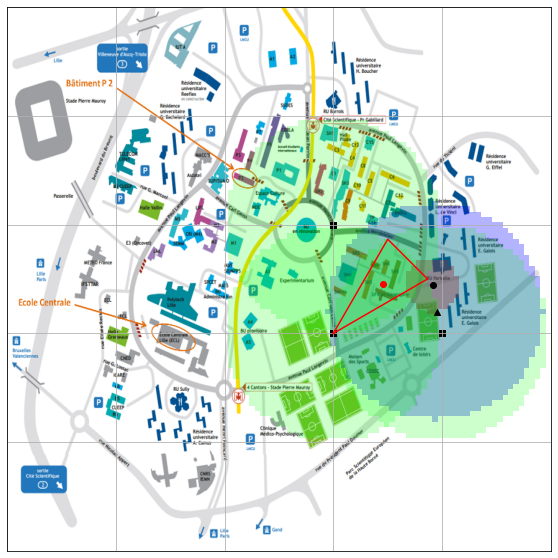

In [11]:
c1 = np.sqrt((G_x-max_loc[0, 0])**2+(G_y-max_loc[0, 1])**2)
m1 = np.where(c1<search_step_size, True, False)
c2 = np.sqrt((G_x-max_loc[1, 0])**2+(G_y-max_loc[1, 1])**2)
m2 = np.where(c2<search_step_size, True, False)
c3 = np.sqrt((G_x-max_loc[2, 0])**2+(G_y-max_loc[2, 1])**2)
m3 = np.where(c3<search_step_size, True, False)

# Display
fig, ax = plt.subplots()
ax.imshow(background, extent=[0, 1000, 0, 1000])

ax.scatter(x[0], x[1], color="black", marker="o")
ax.imshow(mask_AOI, alpha=.4, origin='lower', extent=[0, 1000, 0, 1000], cmap=cmapred)

ax.scatter(z[0], z[1], color="black", marker='^')
ax.imshow(mask_AOR, alpha=.3, origin='lower', extent=[0, 1000, 0, 1000], cmap=cmapblue)

ax.scatter(max_loc[0, 0], max_loc[0, 1], color="black", marker='s')
ax.imshow(m1, alpha=.2, origin='lower', extent=[0, 1000, 0, 1000], cmap=cmapgreen)
ax.scatter(max_loc[1, 0], max_loc[1, 1], color="black", marker='s')
ax.imshow(m2, alpha=.2, origin='lower', extent=[0, 1000, 0, 1000], cmap=cmapgreen)
ax.scatter(max_loc[2, 0], max_loc[2, 1], color="black", marker='s')
ax.imshow(m3, alpha=.2, origin='lower', extent=[0, 1000, 0, 1000], cmap=cmapgreen)

ax.plot(list(intersections[:,0])+[intersections[0,0]], 
        list(intersections[:,1])+[intersections[0,1]], color='red')
ax.scatter(centroid[0], centroid[1], color='red')

ax.set_xticks(np.arange(0,1001, search_step_size))
ax.set_yticks(np.arange(0,1001, search_step_size))
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.grid()
plt.show()

# <span style="color:red">Je n'arrive a rien ! </span>